In [13]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Load the data

In [14]:
fish_dir = '../Fish_Dataset' 

path = []
label = []


for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if filename.endswith('.png') and 'GT' not in dir_name:
            
            folder_name = dir_name.split(os.sep)[-1]
            
            label.append(folder_name)
            path.append(os.path.join(dir_name, filename))


data = pd.DataFrame({'path': path, 'label': label})

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [16]:
data['label'].value_counts(ascending=True)

label
Black Sea Sprat       1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Red Mullet            1000
Red Sea Bream         1000
Sea Bass              1000
Shrimp                1000
Striped Red Mullet    1000
Trout                 1000
Name: count, dtype: int64

Divide the dataset into training, validating and testing data

In [17]:
x_train, x_test = train_test_split(data, test_size=0.2, random_state=30, stratify=data['label'])
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30, stratify=x_train['label'])

In [18]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5760, 2)
Shape of test data (1800, 2)
Shape of validation data (1440, 2)


Preprocess the image

In [19]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [20]:
# Define the labels in sorted order
labels = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel',
          'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp',
          'Striped Red Mullet', 'Trout']
unique_labels = sorted(set(labels))

In [21]:
def random_saturation_contrast_hue(image):
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.05)
    return image

image_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=(0.8, 1.2),
    preprocessing_function=random_saturation_contrast_hue)

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='path', y_col='label', target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, class_names=unique_labels)


test_data_generator = ImageDataGenerator(rescale=1./255)

val = test_data_generator.flow_from_dataframe(dataframe=x_val, x_col='path', y_col='label', target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False, class_names=unique_labels)

test = test_data_generator.flow_from_dataframe(dataframe=x_test, x_col='path', y_col='label', target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False, class_names=unique_labels)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


Define the model

In [22]:
cnn_model = tf.keras.models.Sequential()

# Input Layer
cnn_model.add(tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

# Layer 1
cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Layer 2
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Layer 3
cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Layer 4
cnn_model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Global Average Pooling
cnn_model.add(tf.keras.layers.GlobalAveragePooling2D())

# Fully Connected Layers
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.4))
cnn_model.add(tf.keras.layers.Dense(9, activation='softmax'))

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,441 (1.75 MB)

 Trainable params: 457,481 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

In [23]:
Epochs = 50

save_path = f"../saved_models/cnn_1_model.keras"

Train the model

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Learning Rate Scheduler - ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',         # Metric to monitor (validation loss in this case)
    factor=0.2,                 # Factor by which the learning rate will be reduced
    patience=3,                 # Number of epochs with no improvement before reducing lr
    verbose=1,                  # Print out messages when the learning rate is reduced
    min_lr=1e-6                 # Minimum learning rate to prevent it from going to 0
)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=6,                 # Number of epochs to wait for improvement before stopping
    restore_best_weights=True,  # Restore the best model weights
    verbose=1                   # Print when early stopping occurs
)

# ModelCheckpoint Callback to save the best model
checkpoint_callback = ModelCheckpoint(
    filepath=save_path,         # Path to save the model
    monitor='val_loss',         # Metric to monitor
    save_best_only=True,        # Save only the best model
    mode='min',                 # Save when 'val_loss' is minimized
    verbose=1                   # Print information about saving
)

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=["accuracy"])

# Fit the model with all the callbacks
history = cnn_model.fit(
    train,
    validation_data=val,
    epochs=Epochs,
    callbacks=[checkpoint_callback, early_stopping, lr_scheduler]
)


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2958 - loss: 2.0275
Epoch 1: val_loss improved from inf to 3.48691, saving model to cnn_1_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.2962 - loss: 2.0258 - val_accuracy: 0.2521 - val_loss: 3.4869 - learning_rate: 0.0100
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4758 - loss: 1.4014
Epoch 2: val_loss improved from 3.48691 to 1.31016, saving model to cnn_1_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.4758 - loss: 1.4011 - val_accuracy: 0.5229 - val_loss: 1.3102 - learning_rate: 0.0100
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5257 - loss: 1.2724
Epoch 3: val_loss improved from 1.31016 to 1.20041, saving model to cnn_1_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.5258 - loss: 1.2722 - val_accuracy: 0.5340 - val_loss: 1.2004 - learning_rate: 0.0100
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.

Check the model's performance

In [25]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

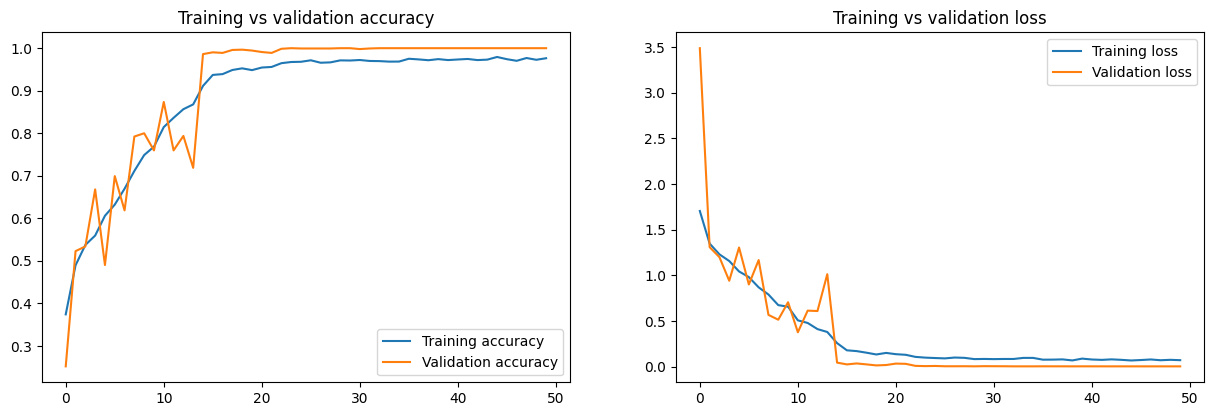

In [34]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

Load saved model and make prediction

In [27]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(save_path)

# Optionally, print the model's summary to verify the structure
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,373,405 (5.24 MB)

 Trainable params: 457,481 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 914,964 (3.49 MB)

In [28]:
# Get predictions from the model
pred = model.predict(test)
pred = np.argmax(pred, axis=1)  # Convert the one-hot encoded predictions to class indices

57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step


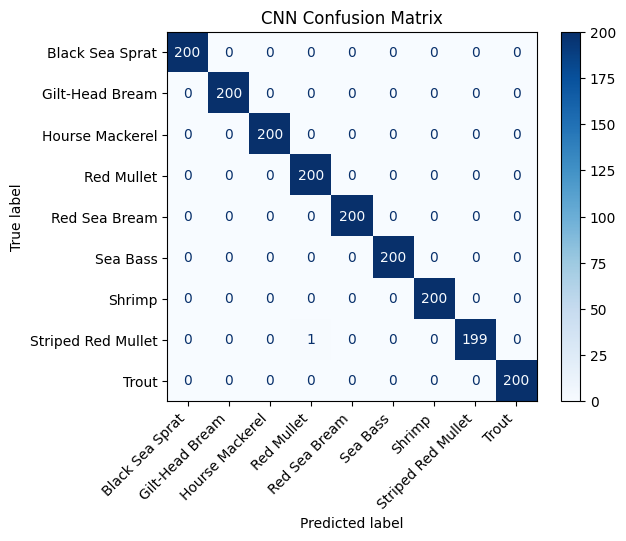


Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       200
   Gilt-Head Bream       1.00      1.00      1.00       200
   Hourse Mackerel       1.00      1.00      1.00       200
        Red Mullet       1.00      1.00      1.00       200
     Red Sea Bream       1.00      1.00      1.00       200
          Sea Bass       1.00      1.00      1.00       200
            Shrimp       1.00      1.00      1.00       200
Striped Red Mullet       1.00      0.99      1.00       200
             Trout       1.00      1.00      1.00       200

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



In [29]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Get the true labels from the test generator
true_labels = test.labels

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(test.class_indices.keys()))
disp.plot(cmap='Blues', values_format='d')  # Customize the color map and format for values
plt.title("CNN Confusion Matrix")  # Add a title
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Generate classification report
class_report = classification_report(true_labels, pred, target_names=list(test.class_indices.keys()))

# Print the classification report
print("\nClassification Report:")
print(class_report)


In [30]:
test_accuracy = model.evaluate(test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 316ms/step - accuracy: 0.9989 - loss: 0.0060


In [31]:
# Training and validation accuracy of the saved model
min_val_loss_index = val_loss.index(min(val_loss))

min_val_loss = val_loss[min_val_loss_index]
corresponding_accuracy = accuracy[min_val_loss_index]
corresponding_val_accuracy = val_accuracy[min_val_loss_index]

print(f"Minimum Validation Loss: {min_val_loss}")
print(f"Training Accuracy at Min Val Loss: {corresponding_accuracy}")
print(f"Validation Accuracy at Min Val Loss: {corresponding_val_accuracy}")


Minimum Validation Loss: 0.005664931610226631
Training Accuracy at Min Val Loss: 0.9703124761581421
Validation Accuracy at Min Val Loss: 1.0
